# Loading required packages/libraries

In [1]:
import gpetas
import numpy as np
import datetime
time_format = "%Y-%m-%d %H:%M:%S.%f"

# auto reload using developer version
%load_ext autoreload
%autoreload 2

# 1) Define domain
One has to specify following aspects of the domain of the data:

* time domain
    * time borders for the training T_borders_training
    * time borders for the testing T_borders_testing
    * time origin (when was '0.' days) given by a *datetime* format: '%Y-%m-%d %H:%M:%S.%f'
* spatial domain X_borders
* domain of the marks (magnitudes) usually by m0

In [2]:
#=========================================
#=========================================
### (1) Setup domain obj
#=========================================
#=========================================



#=========================================
# 1a) time domain
#=========================================
time_origin = '2010-01-01 00:00:00.0'
time_end = '2022-01-01 00:00:00.0'
T_borders_training = np.array([0.,3000.]) # in days

time_origin_obj = datetime.datetime.strptime(time_origin, time_format).replace(tzinfo=datetime.timezone.utc)
time_end_obj = datetime.datetime.strptime(time_end, time_format).replace(tzinfo=datetime.timezone.utc)
delta_Tall=(time_end_obj-time_origin_obj).total_seconds()/(60.*60.*24)
T_borders_all = np.array([0.,delta_Tall])
if T_borders_training[1]>delta_Tall:
    T_borders_training[1] = 0.5*delta_Tall
    print('T_borders_training[1] reset to=',T_borders_training[1])

#=========================================
# 1b) spatial domain
#=========================================
X_borders = np.array([[-120., -113.],[  30.,   37.]]) # [[xrange longitudes],[yrange latitudes]] in degrees

#=========================================
# mark domain: [m0,+inf)
#=========================================
m0=3.5


#=========================================
# 1c) generate domain_obj
#=========================================
domain_obj = gpetas.domain_setup.domain_class()
domain_obj.T_borders_all = T_borders_all
domain_obj.T_borders_training=T_borders_training
domain_obj.T_borders_testing = np.array([T_borders_training[1],T_borders_all[1]])
domain_obj.time_origin = time_origin
domain_obj.X_borders = X_borders
domain_obj.m0 = m0
# case_name (optional)
# domain_obj.case_name = case_name
vars(domain_obj)

{'T_borders_all': array([   0., 4383.]),
 'T_borders_training': array([   0., 3000.]),
 'T_borders_testing': array([3000., 4383.]),
 'X_borders': array([[-120., -113.],
        [  30.,   37.]]),
 'X_borders_UTM_km': None,
 'X_borders_original': None,
 'time_origin': '2010-01-01 00:00:00.0',
 'm0': 3.5,
 'case_name': 'Rxxx'}

# 2) Data from an online source using pycsep
Data can be easily downloaded from online sources as
* USGS: HOST = 'earthquake.usgs.gov' for California

Here we use functionalities provided by the ``pycsep`` package which 
facilitates the data access.

``pycsep`` provides access to the 
ComCat web API and to the 
Bollettino Sismico Italiano API using
* csep.query_comcat()
* csep.query_bsi().

Make sure that pycsep is installed, otherwise install pycsep package with the 
``gpetas_env`` activated:
```python
conda activate gpetas_env
conda install --channel conda-forge pycsep
```


Fetched ComCat catalog in 13.620669841766357 seconds.

Downloaded catalog from ComCat with following parameters
Start Date: 2010-01-04 00:02:17.990000+00:00
End Date: 2021-12-19 10:27:35.704000+00:00
Min Latitude: 30.0063 and Max Latitude: 36.989
Min Longitude: -119.9986667 and Max Longitude: -113.1498
Min Magnitude: 3.5
Found 1688 events in the ComCat catalog.
jitter= 1.5046296084619826e-06
    Values at idx [695] and [696] (counting from 0 to n-1) are the same.
    Time: [968.88711481] [968.88711481]  days.
    NEW Times: [968.88711481] [968.88711632]  days.
NEW number of time duplicates= 0
----------------------------------------------------------------------
total number of events =  1688
time origin            =  2010-01-01 00:00:00+00:00
Starting time          = 0.0 time max= 4383.0
T_borders all          = [   0. 4383.]
|T|                    = 4383.0  days.
T_borders training     = [   0. 3000.]
min event time         = 3.0015971064814817
max event time         = 4370.435829907

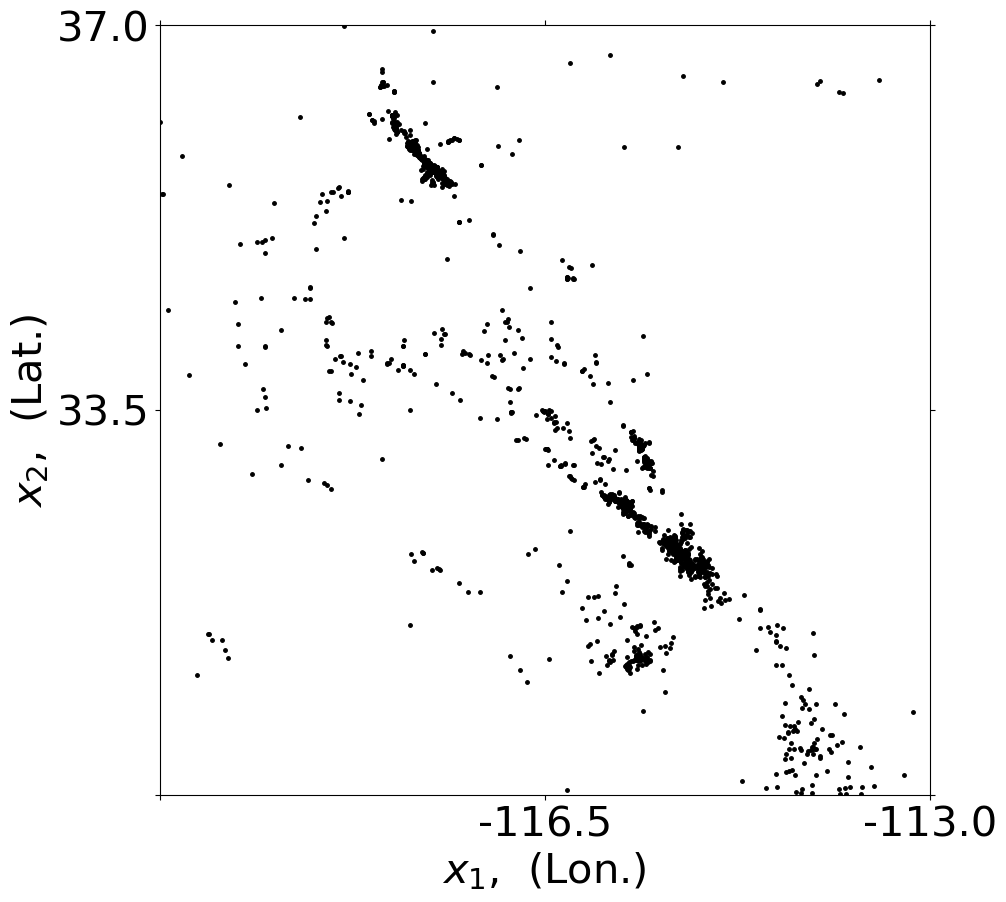

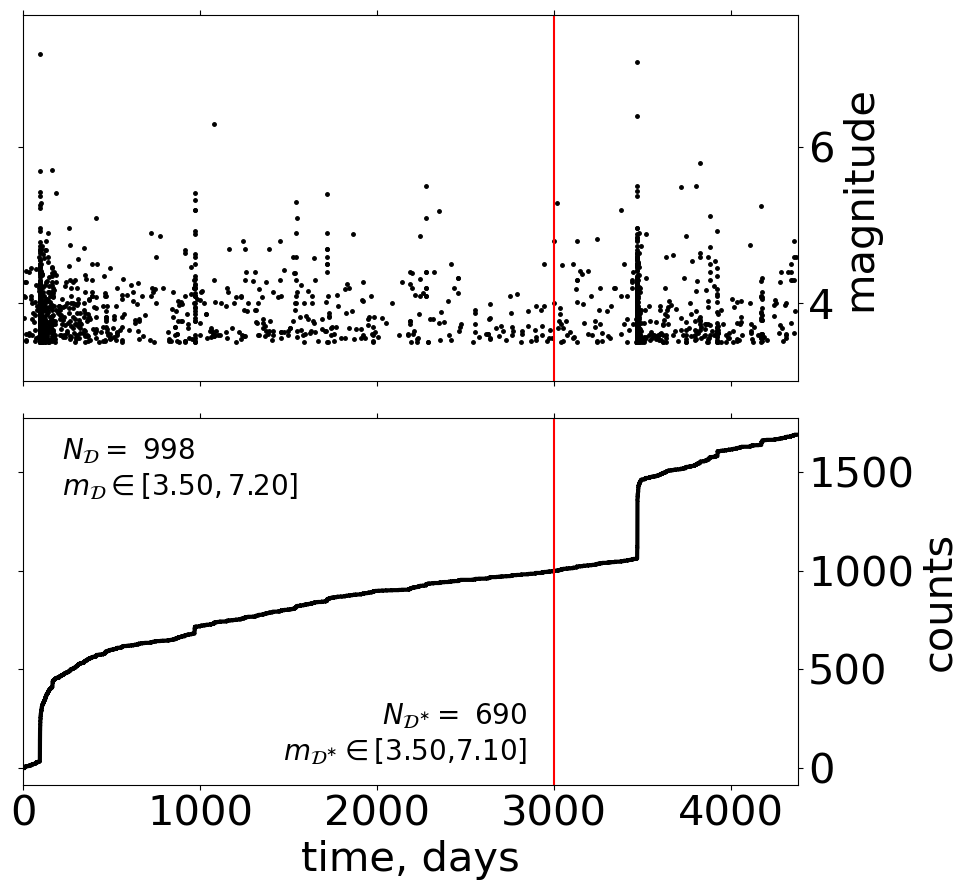

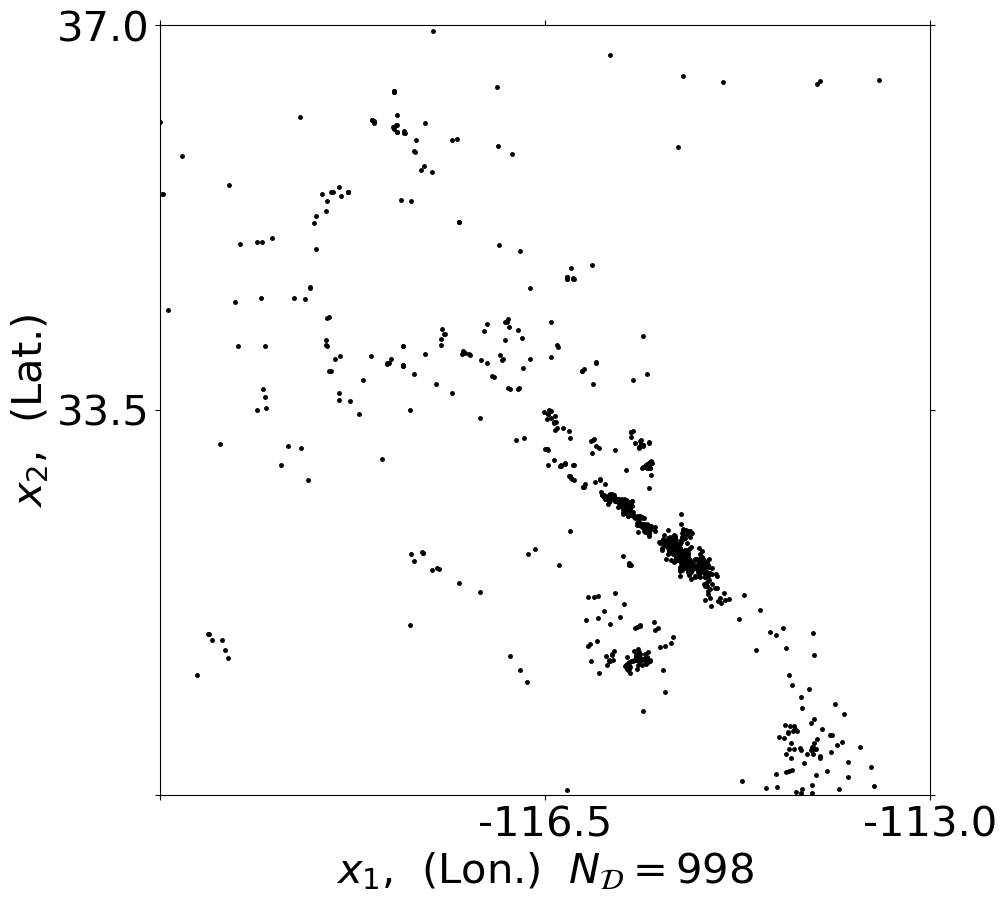

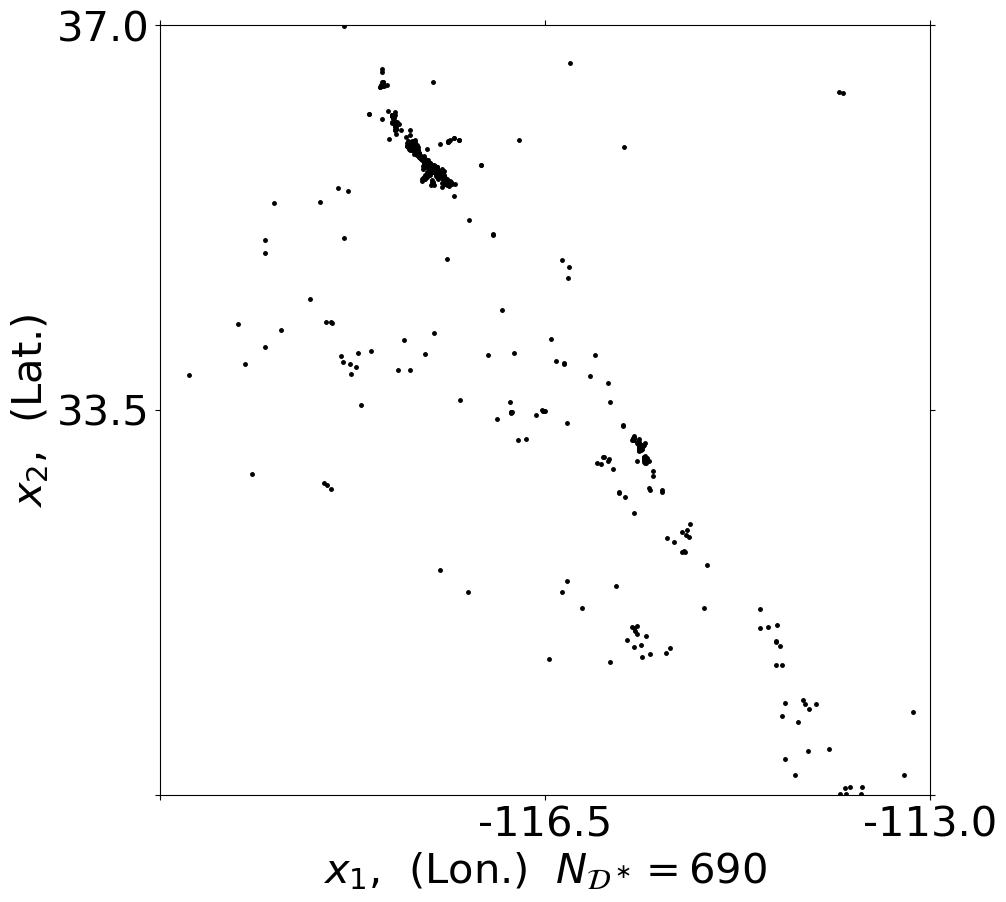

In [3]:
#=========================================
#=========================================
### (2) Download data and generate data_object
#=========================================
#=========================================
# generate data_obj with download data from online comcat source using pycsep
# get pycsep catalog object
# install pycsep first using conda: conda install --channel conda-forge pycsep
import csep
from csep.utils import comcat

#=========================================
# 2a) get data
#=========================================
start_time = datetime.datetime.strptime(domain_obj.time_origin, time_format).replace(tzinfo=datetime.timezone.utc)
end_time = start_time + datetime.timedelta(days=np.diff(domain_obj.T_borders_all).item())
min_magnitude=domain_obj.m0
min_latitude=domain_obj.X_borders[1,0]
max_latitude=domain_obj.X_borders[1,1]
min_longitude=domain_obj.X_borders[0,0]
max_longitude=domain_obj.X_borders[0,1]
catalog_obj = csep.query_comcat(start_time=start_time, end_time=end_time, 
                        min_magnitude=min_magnitude, 
                        min_latitude=min_latitude,max_latitude=max_latitude, 
                        min_longitude=min_longitude, max_longitude=max_longitude)

#=========================================
# 2b) generate gpetas data_object and saves is it into './output/inference_results/data_obj_Rxxx.all'
#=========================================
data_obj = gpetas.utils.get_data_pycsep.data_obj__from_catalog_obj(catalog_obj=catalog_obj,R_obj=domain_obj)
h=gpetas.plotting.plot_setting(data_obj=data_obj)

# 3) Inference setup
In order to perform inference (Bayesian or Maximum Likelihood)
one needs to define or setup several auxiliary variables.
This is done by creating a ***setup_obj*** for the inference which 
includes all required information of the
* Bayesian inference, i.e., Gibbs sampling procedure with Gaussian process 
modelling of the background intensity (GP-ETAS, gpetas) or
* classical Maximum Likelihood estimation (MLE) using a kernel density estimator 
for the background intensity

## 3.1) Setup object for Bayesian inference (Gibbs sampler)
Sampling the posterior requires a
*setup_obj*, which contains everything
one needs for inference: data, domain definition, setup variables (Gibbs sampling parameters).

The inference procedure requires the following:
* Specification of the ***domain*** of the analysis specified in *domain_obj* which is included in the *data_obj*
* ***Data*** stored in a *data_obj* which includes *domain_obj*
* ***parameters of the Gibbs sampler***, e.g., burn-in, number of posterior samples, start values etc. saved in *setup_obj*

In [4]:
#=========================================
#=========================================
### (3.1) Setup object of the Gibbs sampler
#=========================================
#=========================================


#=========================================
# 3.1a) Loading data_obj which includes
#                        domain_obj
#=========================================
case_name = 'Rxxx'
fname = './output/inference_results/data_obj_%s.all'%(case_name) #prevously in 2) generated and saved
data_obj = np.load(fname,allow_pickle=True)



#=========================================
# 3.1b) variables of the Gibbs sampler
#=========================================
# sampler parameters
burnin = 10                               # number of discared initial samples. default: 5000
Ksamples = 20                             # number of samples of the joint posterior default: 500 (a few hundreds)
thinning = 5                              # default:10 # or 20:thinning of the obtained samples in order to avoid autocorrelation
MH_proposals_offspring = 100               # Number of MH proposals for offspring params
MH_cov_empirical_yes = None                # using empirical cov for proposal distribution
sigma_proposal_offspring_params = None     # uses default values: 0.01**2 # alternatives:0.03**2
kth_sample_obj = None                      # starting sampling from kth sample 
num_iterations = Ksamples*thinning+1
print('#iters',num_iterations)


# offspring
prior_theta_dist = 'gamma'                 # specifies prior distribution either 'gamma' or 'uniform'
prior_theta_params = None
theta_start_Kcpadgq = None                 # uses default values:
spatial_offspring = 'R'                    # alternatives: 'G' gaussian 
stable_theta_sampling = None #'yes'              # constraint on theta that only stable Hawkes processes are allowed


# background: 
cov_params = None                          # start values of hypers, uses default: silverman rule
mu_nu0 = None                              # mean of hyper prior on nu_0, uses default value:



# background: spatial resolution for plotting/evaluations
ngrid_per_dim = 50                         # default value: 50 corresponds to a 50x50 grid over X domain
X_grid = gpetas.some_fun.make_X_grid(data_obj.domain.X_borders, nbins=ngrid_per_dim)
                                           # generates spatial grid for plotting etc.
    
# general 
time_origin = data_obj.domain.time_origin
case_name = data_obj.case_name
    
# save results
output_dir = './output/inference_results'
outdir = output_dir


# Generating GS sampler setup_obj
setup_obj = gpetas.setup_Gibbs_sampler.setup_sampler(data_obj=data_obj,
             utm_yes=None,
             spatial_offspring=spatial_offspring,
             theta_start_Kcpadgq=theta_start_Kcpadgq,
             sigma_proposal_offspring_params=sigma_proposal_offspring_params,
             ngrid_per_dim=ngrid_per_dim,
             cov_params=cov_params,
             mu_nu0=None,
             X_grid=X_grid,
             outdir=outdir,
             prior_theta_dist=prior_theta_dist,
             prior_theta_params=prior_theta_params,
             stable_theta_sampling=stable_theta_sampling,
             time_origin=time_origin,
             case_name=case_name,
             burnin=burnin, 
             Ksamples=Ksamples,
             num_iterations=num_iterations,
             thinning=thinning,
             MH_proposals_offspring=MH_proposals_offspring,
             MH_cov_empirical_yes=MH_cov_empirical_yes,
             kth_sample_obj=kth_sample_obj)

#iters 101
Output subdirectory exists
setup_obj has been created and saved: ./output/inference_results/setup_obj_Rxxx.all


# 4) Inference: gpetas and MLE
Inference can be done ***in the terminal*** using ``demo_inference_setup_obj_v008.py`` 
program.

This program does ***Gibbs sampling and MLE*** automatically using 
the setup of the Gibbs sampler also for MLE.

The ``demo_inference_setup_obj_v008.py`` requires only one argument, namely 
the *setup_obj file*.
Make sure that *gpetas_env* is activated first.

In the terminal type:

```
python3.9 demo_inference_setup_obj_v008.py --fsetup output/inference_results/setup_obj_Rxxx.all
```

In order to avoid MLE computiations and only perform Gibbs sampling type,

```
python3.9 demo_inference_setup_obj_v008.py --fsetup output/inference_results/setup_obj_Rxxx.all --mle_yes no --mle_yes_silverman no
```

# 5) Inference: Results
First inference results are 
* plots in subdirectory 
***output/inference_results/figures***.
* offspring parameter values in 
***output/inference_results/tables***.

Figures of the results can be automatically plotted using routines
in *gpetas.plotting.plot_...*, e.g.,

In [8]:
fname='output/inference_results/GS_save_data_Rxxx.bin'
save_obj_GS = np.load(fname,allow_pickle=True)
fname='output/inference_results/mle_default_hmin_Rxxx.all'
mle_obj = np.load(fname,allow_pickle=True) #default
fname='output/inference_results/mle_silverman_hmin_Rxxx.all'
mle_obj_silverman = np.load(fname,allow_pickle=True)

testing periods
[[   0. 3000.]
 [3000. 4383.]] days.
Number of employed posterior samples: 20
Current T_star_testing = [   0. 3000.]
Employed number of posterior samples: 20
Current T_star_testing = [3000. 4383.]
Employed number of posterior samples: 20
gpetas: [-351.0894582 2342.6211835] Events: [998. 690.]
MLE: [-329.54148933] [2324.6391341] Events: 998 690
MLE: [-375.50806744] [2300.76423007] Events: 998 690


(<Figure size 1000x750 with 2 Axes>, <Figure size 1000x400 with 2 Axes>)

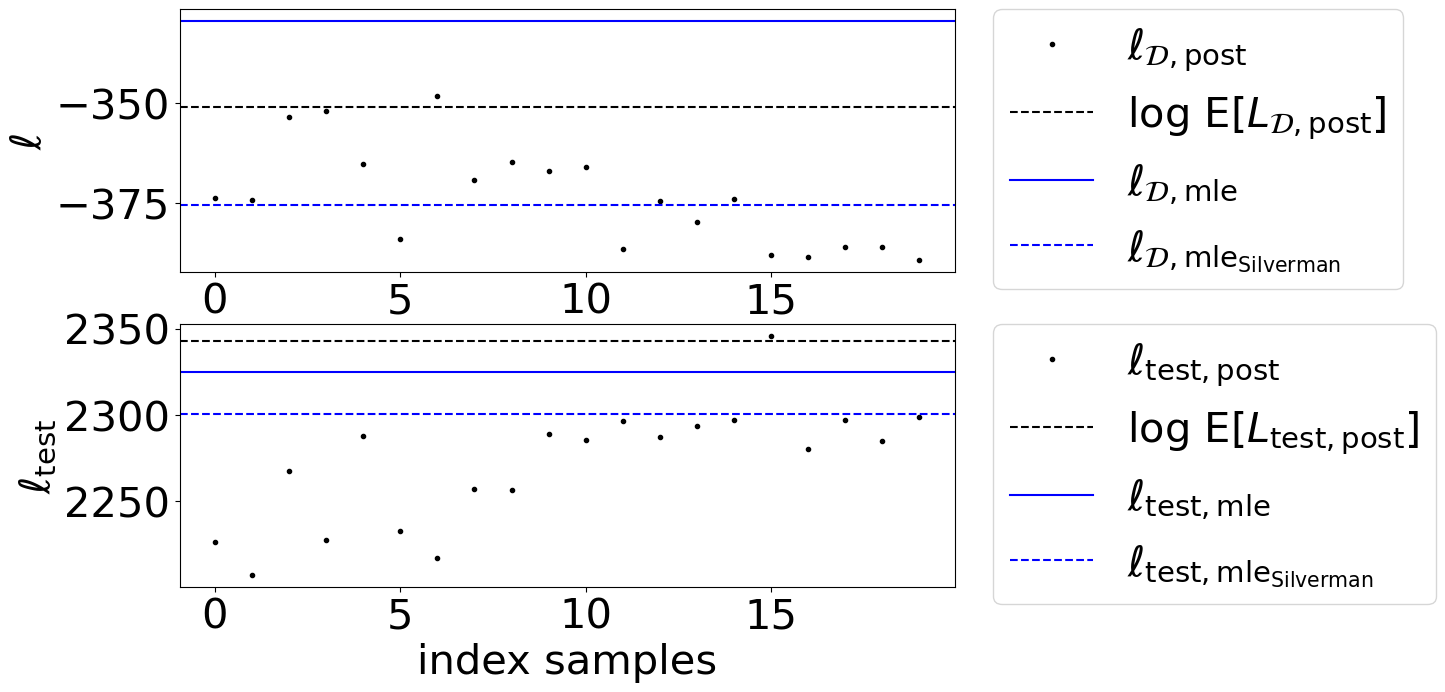

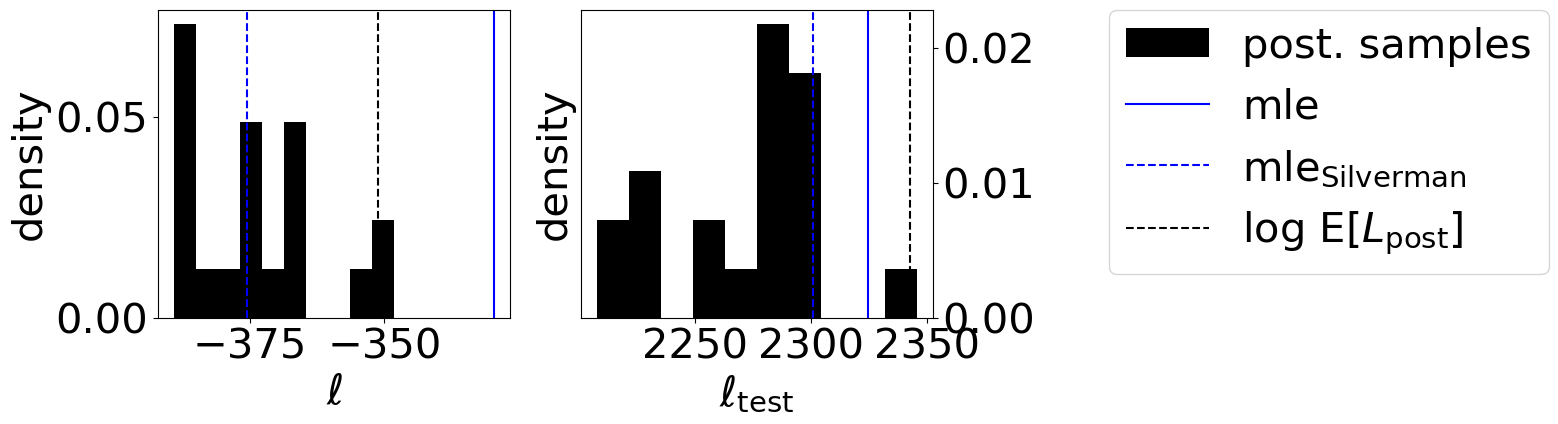

In [13]:
gpetas.plotting.plot_l_ltest(save_obj_GS=save_obj_GS,mle_obj=mle_obj,mle_obj_silverman=mle_obj_silverman)

In [ ]:
m_big = 6.
t_i_big_shocks = data_obj.data_all.times[np.where(data_obj.data_all.magnitudes>m_big)]
t_i_big_shocks_in_testing = t_i_big_shocks[t_i_big_shocks>=data_obj.domain.T_borders_training[1]]
print(t_i_big_shocks_in_testing)
t1=t_i_big_shocks_in_testing[0]
t2=t1+180.
gpetas.plotting.plot_l_ltest(t1=t1,t2=t2,save_obj_GS=save_obj_GS,mle_obj=mle_obj,mle_obj_silverman=mle_obj_silverman)

[3471.73181713 3473.13880833]
testing periods
[[   0.         3000.        ]
 [3471.73181713 3651.73181713]] days.
Number of employed posterior samples: 20
Current T_star_testing = [   0. 3000.]


[3471.73181713 3473.13880833]
